# EDA

## Importación de librerías

In [1]:
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Constantes

Rutas usuales que se ocuparán en el notebook

In [2]:
# Salvar gráficos
save_graf = False

# RUTAS
MAIN_PATH = os.path.join("..")

IMG_PATH = os.path.join(MAIN_PATH, "imagenes")
DATA_PATH = os.path.join(MAIN_PATH, "data")

WF_FOLDER_PATH = os.path.join(DATA_PATH,
                              "wildfires_us")
WF_DATA_PATH = os.path.join(WF_FOLDER_PATH,
                            "WILDFIRES_USA.csv")
WF_DATA_COLUMNS_PATH = os.path.join(WF_FOLDER_PATH,
                                    "WILDFIRES_USA_COLUMNS.csv")

# Tamaño de la imagen
my_figsize = (10, 5)

## Funciones auxiliares

Función que se ocupará para imprimir la información (número de filas y columnas) de un DataFrame.

In [3]:
def print_cantidad(dataframe):
    """Imprime la cantidad de datos que tiene el Data Frame.
    """
    msg_cantidad = "El dataset tiene una cantidad de {} datos y {} variables."
    print(msg_cantidad.format(dataframe.shape[0], dataframe.shape[1]))
    return None

Función que define el estilo de todos los gráficos

In [4]:
def estilo():
    """Define el estilo general de los gráficos.
    """
    # Configuraciones
    sns.set(
        context="notebook",
        style="whitegrid",
        palette="pastel",
        font_scale=1.3
    )

Función que servirá para graficar con el dataframe

In [5]:
def plot_barh(df, columna, save=save_graf, n_datos=None, title=None, sort=True):
    """Plotea un gráfico de barras horizontales.
    Se especifica el dataframe y la columna con que se graficará
    """
    estilo()

    titulo = ("Número de incendios"
              + f" para la columna {columna}.") if title is None else title

    if n_datos is None:
        ax = df[columna].value_counts(sort=sort).plot(
            kind="barh",
            figsize=my_figsize,
        )
    else:
        ax = df[columna].value_counts(sort=sort).head(n=n_datos).plot(
            kind="barh",
            figsize=my_figsize,
        )
        
    ax.set_xlabel("Número de incendios")
    ax.set_ylabel(columna)
    ax.set_title(titulo)

    if save:
        plt.savefig(os.path.join(IMG_PATH, f"barh_{columna}.pdf"))

Para graficar un mapa

In [6]:
def graf_map(df, n_sample=2500):
    """Plotea un mapa de USA con sus incendios.
    """
    import folium
    import random

    # Inspiración: 
    # https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

    state_geo = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/search_states.json"

    state_uneployment = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/US_Unemployment_Oct2012.csv"

    state_data = pd.read_csv(state_uneployment)

    m = folium.Map(location=[48, -102], zoom_start=3, width=800, height=500)

    lat_long = list(zip(df["LATITUDE"], df["LONGITUDE"]))

    random.seed(1314)
    for lat, long in random.sample(lat_long, 2500):
        folium.CircleMarker(
            [lat, long],
            color="red",
            fill=True,
            fill_opacity=0.2,
            radius=1,
        ).add_to(m)

    return m

## Carga de datos

### Columnas a ocupar

Se escojen las columnas a ocupar dependiendo de la importancia que tenga. Se omiten algunas columnas tales como las que son para el ID, como el nombre que tuvo el incendio, o la columna que indica de dónde se obtuvo el incendio; pues no deberían de afectar a la predicción.

In [7]:
# Todas las columnas
columnas = str(pd.read_csv(WF_DATA_COLUMNS_PATH).columns[0]).split(",")

# Columnas que se ocuparán en el análisis
columnas_ocupadas = columnas.copy()

# Columnas que no se ocuparán
columnas_sin_ocupar = [x for x in columnas if x not in columnas_ocupadas]

### Carga de Datos

In [8]:
df = pd.read_csv(WF_DATA_PATH)

# Convertimos los datos que sean fechas en ese tipo de dato
df["DISC_DATE_TIME"] = pd.to_datetime(df["DISC_DATE_TIME"])
df["CONT_DATE_TIME"] = pd.to_datetime(df["CONT_DATE_TIME"])

print_cantidad(df)

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


El dataset tiene una cantidad de 581159 datos y 17 variables.


,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_NAME,DISC_DATE_TIME,DISC_MONTH,DISC_DAY_OF_WEEK,DISC_TIME,CONT_DATE_TIME,CONT_MONTH,CONT_DAY_OF_WEEK,CONT_TIME
0,2005,Miscellaneous,0.10,A,40.036944,-121.005833,CA,63,Plumas,2005-02-02 13:00:00,February,Wednesday,13,2005-02-02 17:30:00,February,Wednesday,17
1,2004,Lightning,0.25,A,38.933056,-120.404444,CA,61,Placer,2004-05-12 08:45:00,May,Wednesday,8,2004-05-12 15:30:00,May,Wednesday,15
2,2004,Debris Burning,0.10,A,38.984167,-120.735556,CA,17,El Dorado,2004-05-31 19:21:00,May,Monday,19,2004-05-31 20:24:00,May,Monday,20
3,2004,Lightning,0.10,A,38.559167,-119.913333,CA,3,Alpine,2004-06-28 16:00:00,June,Monday,16,2004-07-03 14:00:00,July,Saturday,14
4,2004,Lightning,0.10,A,38.559167,-119.933056,CA,3,Alpine,2004-06-28 16:00:00,June,Monday,16,2004-07-03 12:00:00,July,Saturday,12


## Análisis de datos

### Primeros gráficos

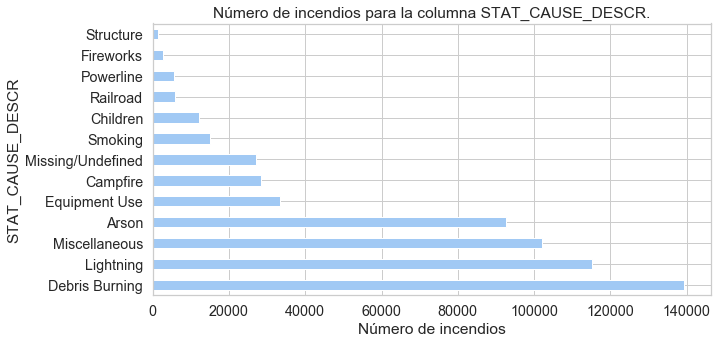

In [9]:
plot_barh(df, "STAT_CAUSE_DESCR")

Observamos que las principales causas de incendio son: `Debris Burning`, `Lightning`, `Miscellaneous` y `Arson`.

Estos, traducidos son: Quema de escombros, Relámpago, Misceláneo e Incendio provocado, respectivamente.

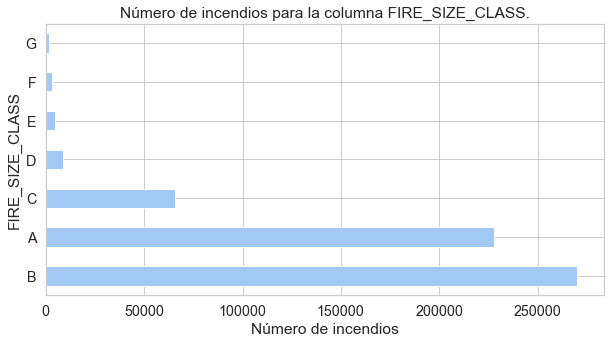

In [10]:
plot_barh(df, "FIRE_SIZE_CLASS")

Se observa que las principales clases de tamaños son: `B`, `A` y `C`.
    
Esto significa que la mayoría de incendios están entre los rangos 0.26-9.9, 0-0.25 y 10.0-99.9 acres respectivamente.

Un acre son 4046.86m2, si lo traducimos:
* `B`:1,052.18-40,063.91m2
* `A`:0.0-1,011.71m2
* `C`:40,468.60-404,281.31m2


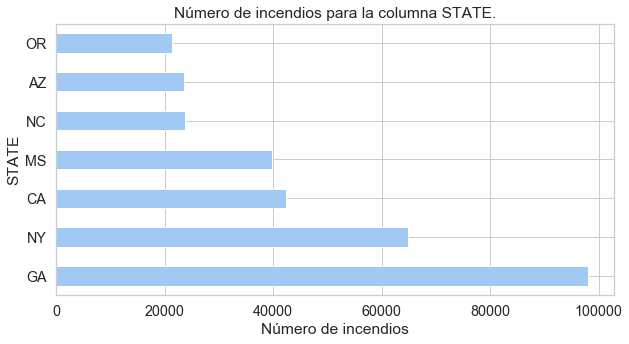

In [11]:
plot_barh(df, "STATE", n_datos=7)

Observamos que la mayoría de incendios se encuentran en Georgia, New York, California y Massachusetts.

In [12]:
graf_map(df)

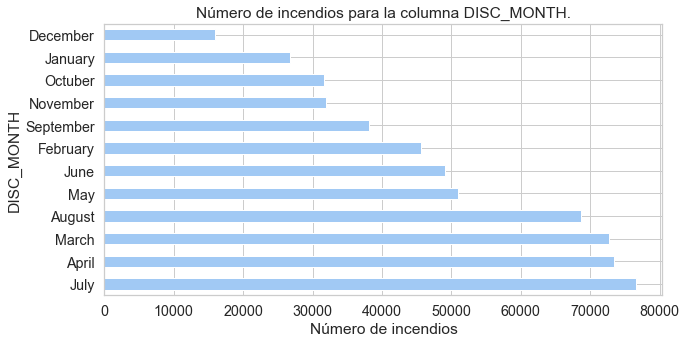

In [13]:
plot_barh(df, "DISC_MONTH", sort=True)

Observamos que la mayoría de incendios ocurren en los meses de julio, abril, marzo y agosto.

Esto se puede deber a que en esos meses ocurren ciertas festividades en USA, aunque se necesita de mayor investigación para afirmarlo.

### Analizar la causa con respecto a algún día de la semana

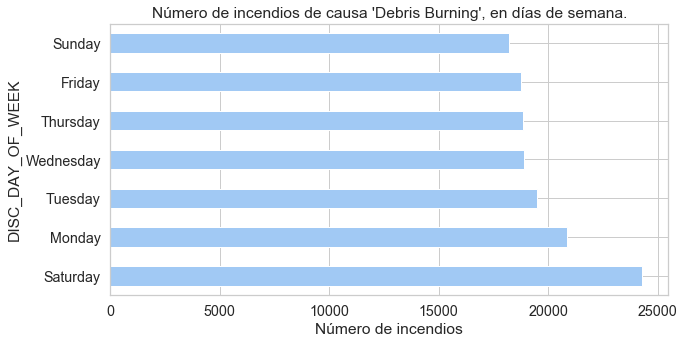

In [14]:
causa = "Debris Burning"
plot_barh(df[df["STAT_CAUSE_DESCR"]==causa], 
          "DISC_DAY_OF_WEEK",
          title=f"Número de incendios de causa '{causa}', en días de semana."
         )

Observamos que el número de incendios por la quema de escombros son más frecuentes los sábados.

Esto se puede explicar porque la gente suele acampar los fines de semana, provocando estos incendios.

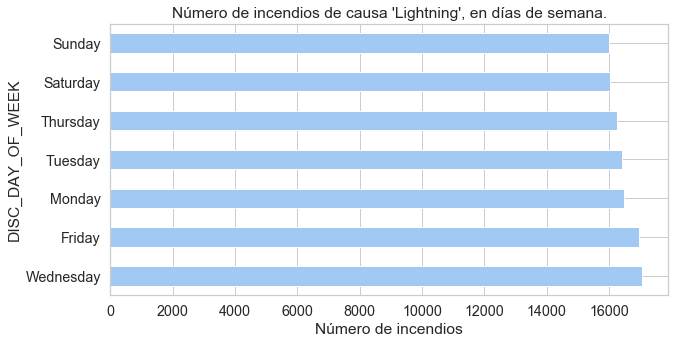

In [15]:
causa = "Lightning"
plot_barh(df[df["STAT_CAUSE_DESCR"]==causa], 
          "DISC_DAY_OF_WEEK",
          title=f"Número de incendios de causa '{causa}', en días de semana."
         )

Observamos que no hay diferencias significativas por la causa de relámpagos. Esto es lo intuitivo, pues es una causa natural y no humana.

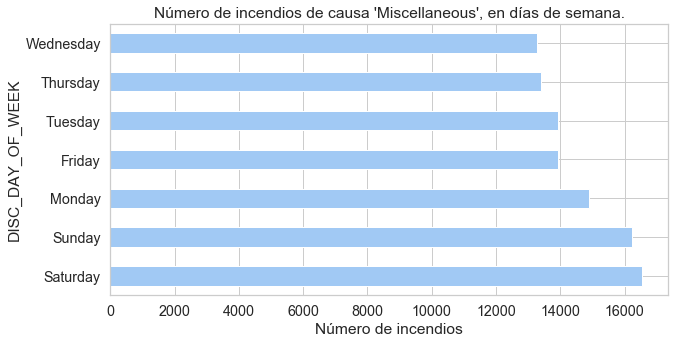

In [16]:
causa = "Miscellaneous"
plot_barh(df[df["STAT_CAUSE_DESCR"]==causa], 
          "DISC_DAY_OF_WEEK",
          title=f"Número de incendios de causa '{causa}', en días de semana."
         )

Observamos que ocurren más incendios los sábados, domingos y lunes de forma miscelánea. Esto se puede explicar de que las personas aprovehan los fines de semanas largos para ir a acampar.

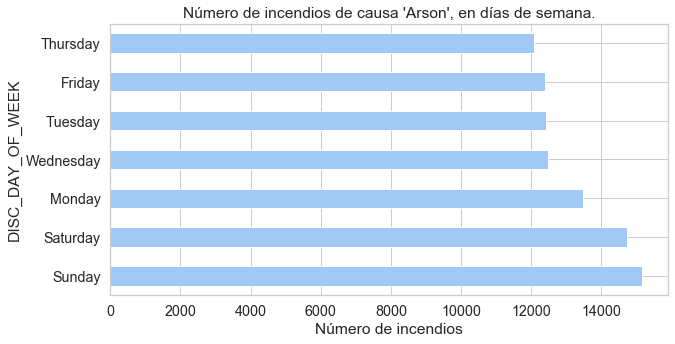

In [17]:
causa = "Arson"
plot_barh(df[df["STAT_CAUSE_DESCR"]==causa], 
          "DISC_DAY_OF_WEEK",
          title=f"Número de incendios de causa '{causa}', en días de semana."
         )

Obtenemos una tendencia similar a la causa miscélanea.

### Gráfico de número de incendios con respecto a la hora

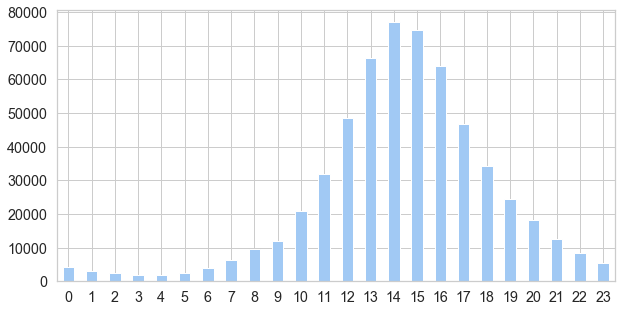

In [18]:
df["DISC_TIME"].value_counts(sort=False).plot(
    kind="bar",
    figsize=my_figsize
)

plt.xticks(rotation=0)
plt.show()

Observamos que se forma una especie de campana, concentrada a las 14.

### Matriz de correlaciones

Realizamos una copia del dataframe y rotulamos las variables categóricas.

In [19]:
df_copy = df.copy()

columnas = [
    "STAT_CAUSE_DESCR",
    "STATE", "DISC_MONTH",
    "DISC_DAY_OF_WEEK",
    "CONT_MONTH",
    "CONT_DAY_OF_WEEK",
    "FIRE_SIZE_CLASS",
]

le = preprocessing.LabelEncoder()
for col in columnas:
    df_copy[col] = le.fit_transform(df_copy[col])

In [20]:
df_copy.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_NAME,DISC_DATE_TIME,DISC_MONTH,DISC_DAY_OF_WEEK,DISC_TIME,CONT_DATE_TIME,CONT_MONTH,CONT_DAY_OF_WEEK,CONT_TIME
0,2005,7,0.10,0,40.036944,-121.005833,4,63,Plumas,2005-02-02 13:00:00,3,6,13,2005-02-02 17:30:00,3,6,17
1,2004,6,0.25,0,38.933056,-120.404444,4,61,Placer,2004-05-12 08:45:00,8,6,8,2004-05-12 15:30:00,8,6,15
2,2004,3,0.10,0,38.984167,-120.735556,4,17,El Dorado,2004-05-31 19:21:00,8,1,19,2004-05-31 20:24:00,8,1,20
3,2004,6,0.10,0,38.559167,-119.913333,4,3,Alpine,2004-06-28 16:00:00,6,1,16,2004-07-03 14:00:00,5,2,14
4,2004,6,0.10,0,38.559167,-119.933056,4,3,Alpine,2004-06-28 16:00:00,6,1,16,2004-07-03 12:00:00,5,2,12


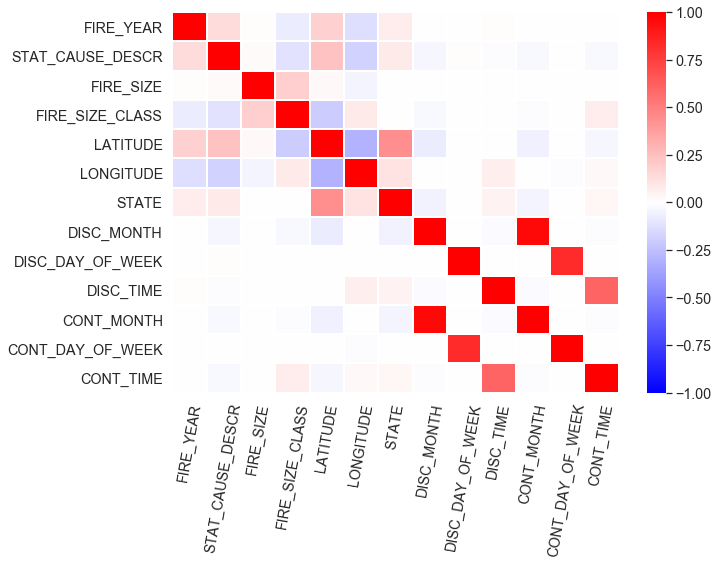

In [24]:
corr_matrix = df_copy.corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(corr_matrix, annot=False,
            vmin=-1, vmax=1, center=0,
            cmap="bwr", linewidths=1, ax=ax
           )

plt.xticks(rotation=80)
plt.show()

Observamos que el el año del incendio tiene correlación con la causa del incendio y el estado. Curiosamente esta variable tiene correlación con la latitud. Puede ser que tenga esta correlación por su correlación con el estado.

La causa del incendio tiene correlación con la latitud y con el estado. Esto se puede deber a que la latitud tiene una alta correlación con el estado.

Observamos que el tamaño del incendio tiene correlación con el tiempo de contención.